In [2]:
import os
from datetime import datetime

In [3]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection  import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

In [4]:
import datetime

In [5]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

In [6]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

# Obtendo e estruturando base classificada de incêndios

In [14]:
df_nasa = pd.read_csv("L:\\nasa\\Fire Detected\\DL_FIRE_V1_157292\\fire_archive_V1_157292.csv",dtype={'acq_time': object})

In [15]:
df_0119 = df_nasa[["acq_date",'confidence','frp','latitude','longitude','bright_ti4','bright_ti5']][(df_nasa["acq_date"] >='2019-01-01')& (df_nasa["acq_date"] <='2019-01-31')]

In [16]:
def classificacao(dfamostra):
    df_final = pd.DataFrame(columns=["acq_date",'confidence','frp','latitude','longitude','bright_ti4','bright_ti5',"fogo","dia"])
    for dia in np.unique(dfamostra.acq_date.values):
        df = dfamostra[dfamostra["acq_date"]==dia]
        df['fogo'] = True
        df['dia'] = dia
        df_final = df_final.append(df)
        df = dfamostra[dfamostra["acq_date"]!=dia]
        df['fogo'] = False
        df['dia'] = dia
        df_final = df_final.append(df)
    return df_final
        

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
df_fogo = classificacao(df_0119)

## Convertendo variáveis categóricas para dummies

In [19]:
confidence = pd.get_dummies(df_fogo['confidence'],drop_first=True)

In [20]:
fogo = pd.get_dummies(df_fogo['fogo'],drop_first=True)

In [21]:
df_fogo_dmy = pd.concat([df_fogo,confidence],axis=1)

In [22]:
df_fogo_dmy['dia'] = df_fogo_dmy.dia.apply(lambda x: to_integer(datetime.datetime.strptime(x,"%Y-%m-%d")))

In [23]:
df_fogo_dmy['fogo'] = fogo

In [24]:
df_fogo_dmy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862296 entries, 9128822 to 9155177
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   acq_date    862296 non-null  object 
 1   confidence  862296 non-null  object 
 2   frp         862296 non-null  float64
 3   latitude    862296 non-null  float64
 4   longitude   862296 non-null  float64
 5   bright_ti4  862296 non-null  float64
 6   bright_ti5  862296 non-null  float64
 7   fogo        862296 non-null  uint8  
 8   dia         862296 non-null  int64  
 9   l           862296 non-null  uint8  
 10  n           862296 non-null  uint8  
dtypes: float64(5), int64(1), object(2), uint8(3)
memory usage: 61.7+ MB


<AxesSubplot:>

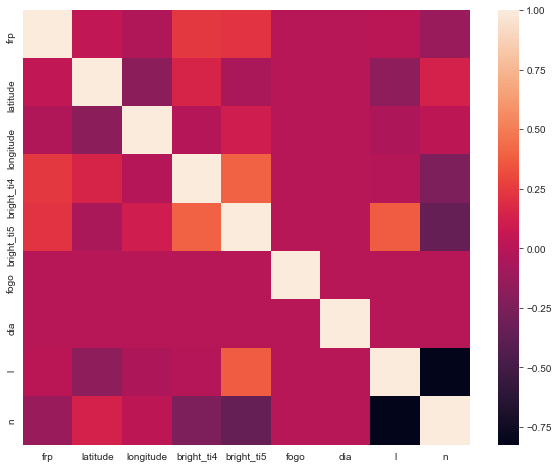

In [25]:
sb.heatmap(df_fogo_dmy.corr())  

#### devido a alta correlação entre a bright_ti4 e bright_ti5 e  bright_ti5 com l a bright_ti5 será descartada.

In [26]:
df_fogo_dmy_core = df_fogo_dmy.drop(["bright_ti5","confidence","acq_date"],1)

In [27]:
df_fogo_dmy_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862296 entries, 9128822 to 9155177
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   frp         862296 non-null  float64
 1   latitude    862296 non-null  float64
 2   longitude   862296 non-null  float64
 3   bright_ti4  862296 non-null  float64
 4   fogo        862296 non-null  uint8  
 5   dia         862296 non-null  int64  
 6   l           862296 non-null  uint8  
 7   n           862296 non-null  uint8  
dtypes: float64(4), int64(1), uint8(3)
memory usage: 41.9 MB


# Preparação dos Históricos Metereológicos

In [85]:
hdf5= "L://nasa//Metereologicos//Inmet//2019//vaex2//"

In [90]:
features = vaex.open_many([hdf5+l for l in os.listdir(hdf5)])

In [232]:
def convert_data(d):
    return datetime.strptime(d.strip(),"%Y/%m/%d")

In [168]:
def convert_string(s):
    if s is not None:
        return float(s.replace(",","."))
    else:
        return s

In [203]:
diasW = features.Data

In [225]:
lista_datas = diasW.tolist()

In [241]:
radiacao_global_KJm2 = features['RADIACAO GLOBAL (KJ/m2)'].apply(lambda x:convert_string(x))

In [233]:
diaslista = [to_integer(convert_data(lt)) for lt in lista_datas]

In [148]:
vent_dir = features['VENTO, DIRECAO HORARIA (gr) ( (gr))']

In [152]:
vento_vel = features['VENTO, RAJADA MAXIMA (m/s)'].apply(lambda x:convert_string(x))

In [149]:
precip_mm = features['PRECIPITACAO TOTAL, HORARIO (mm)'].apply(lambda x:convert_string(x))  

In [153]:
umid_rel_ar = features['UMIDADE RELATIVA DO AR, HORARIA (%)']

In [147]:
tem_pto_orv = features['TEMPERATURA DO PONTO DE ORVALHO (C)'].apply(lambda x:convert_string(x))

In [154]:
temp_ar_bulbo_seco = features['TEMPERATURA DO AR - BULBO SECO, HORARIA (C)'].apply(lambda x:convert_string(x))

In [150]:
altitude = features.altitude.apply(lambda x:convert_string(x))  

In [155]:
press_atm = features['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'].apply(lambda x:convert_string(x))

In [151]:
longitude =  features.longitude.apply(lambda x:convert_string(x))

In [156]:
latitude = features.latitude.apply(lambda x:convert_string(x))

In [166]:
df1 = vaex.from_arrays(latitude=latitude.to_numpy(),longitude=longitude.to_numpy())

In [171]:
df3 = vaex.from_arrays(press_atm=press_atm.to_numpy(),altitude=altitude.to_numpy())

In [170]:
df2 = vaex.from_arrays(temp_ar_bulbo_seco=temp_ar_bulbo_seco.to_numpy(),tem_pto_orv=tem_pto_orv.to_numpy())

In [172]:
df4 = vaex.from_arrays(umid_rel_ar=umid_rel_ar.to_numpy(),precip_mm=precip_mm.to_numpy())

In [173]:
df5 = vaex.from_arrays(vento_vel=vento_vel.to_numpy(),vent_dir=vent_dir.to_numpy())

In [242]:
df6 = vaex.from_arrays(dias_clima = diaslista, radiacao_global_KJm2=radiacao_global_KJm2.to_numpy())

In [176]:
df_vaex_final = df1.join(df2)

In [177]:
df_vaex_final = df_vaex_final.join(df3)

In [178]:
df_vaex_final = df_vaex_final.join(df4)

In [179]:
df_vaex_final = df_vaex_final.join(df5)

In [243]:
df_vaex_final = df_vaex_final.join(df6)

In [249]:
#df_vaex_final.export_hdf5("L://nasa//Metereologicos//Inmet//2019//vaex2//tratado//dataset_202010041955.hdf5")

ERROR:MainThread:root:error creating dataset for 'radiacao_global_KJm2', with type dtype('O') 
Traceback (most recent call last):
  File "C:\Users\Usuario\Anaconda3\envs\Nasa\lib\site-packages\vaex\hdf5\export.py", line 201, in export_hdf5
    array = h5column_output.require_dataset('data', shape=shape, dtype=dtype.newbyteorder(byteorder))
  File "C:\Users\Usuario\Anaconda3\envs\Nasa\lib\site-packages\h5py\_hl\group.py", line 191, in require_dataset
    return self.create_dataset(name, *(shape, dtype), **kwds)
  File "C:\Users\Usuario\Anaconda3\envs\Nasa\lib\site-packages\h5py\_hl\group.py", line 136, in create_dataset
    dsid = dataset.make_new_dset(self, shape, dtype, data, **kwds)
  File "C:\Users\Usuario\Anaconda3\envs\Nasa\lib\site-packages\h5py\_hl\dataset.py", line 118, in make_new_dset
    tid = h5t.py_create(dtype, logical=1)
  File "h5py\h5t.pyx", line 1634, in h5py.h5t.py_create
  File "h5py\h5t.pyx", line 1656, in h5py.h5t.py_create
  File "h5py\h5t.pyx", line 1711, in h5p

In [8]:
#df_vaex_final = vaex.open("L://nasa//Metereologicos//Inmet//2019//vaex2//tratado//dataset_202010041955.hdf5")

# Integrando com a base histórica de incêncio classificada

In [9]:
import geojson
from geopy import distance
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd

In [10]:
pontos_metereo = pd.concat([df_vaex_final.latitude.to_pandas_series(), df_vaex_final.longitude.to_pandas_series()], axis=1)

In [11]:
gdf = gpd.GeoDataFrame(
    pontos_metereo, geometry=gpd.points_from_xy(pontos_metereo[1], pontos_metereo[1]))

In [12]:
destinos  =  MultiPoint(gdf.geometry.values)

In [295]:
y=df_fogo_dmy_core.iloc[1]["latitude"]

In [292]:
x=df_fogo_dmy_core.iloc[1]["longitude"]

In [329]:
import numpy as nu

In [344]:
pt = gpd.points_from_xy(y=[y],x=[x])

In [347]:
nearest_geoms = nearest_points(pt[0], destinos)

In [381]:
df_fogo_dmy_core = df_fogo_dmy_core.drop(['ponto'],1)

In [36]:
df_fogo_dmy_core["ponto"] =     [gpd.points_from_xy(y=[pto['latitude']],x=[pto['longitude']]) for i,pto in df_fogo_dmy_core.iterrows()]

In [38]:
df_fogo_dmy_core.to_pickle("L:\\nasa\\Fire Detected\\DL_FIRE_V1_157292\\tratado\\base1.pickle")

In [ ]:
df_fogo_dmy_core["estac_refer"] = [nearest_points(pm['ponto'][0], destinos) for i,pm in df_fogo_dmy_core.iterrows()]

In [ ]:
#TODO implementar distâcia do ponto ao sensor.
df_fogo_dmy_core["estac_refer"] = 

In [37]:
['radiacao_global_KJm2','vent_dir','vento_vel','precip_mm','umid_rel_ar','tem_pto_orv','temp_ar_bulbo_seco','press_atm','dist_estac']

KeyError: 'estac_refer'

In [ ]:
df_fogo_dmy_core["dist_estac"] = 

In [ ]:
### Cruzar dados de metereológicos com base classificada

# Treinamento do Modelo

In [7]:
import vaex
from vaex.ml.sklearn import Predictor

In [34]:
from sklearn.linear_model import LogisticRegression

In [40]:
df_vaex = vaex.from_pandas(df_fogo_dmy_core)

In [58]:
df_train, df_test = df_vaex.ml.train_test_split(test_size=0.3, verbose=False)

In [59]:
features_linear = ['frp','latitude','longitude','bright_ti4','dia','l','n'] 

In [68]:
vaex_svc = vaex.ml.sklearn.Predictor(features=features_linear,
                                     target='fogo',
                                     model=SVC(max_iter=100, random_state=42),
                                     prediction_name='prediction_svc')

In [69]:
vaex_logistic = vaex.ml.sklearn.Predictor(features=features_linear,
                                          target='fogo',
                                          model=LogisticRegression(max_iter=100, random_state=42),
                                          prediction_name='prediction_lr')

In [70]:
for model in [vaex_svc, vaex_logistic]:
    model.fit(df_train)
    df_train = model.transform(df_train)

# Avaliação do modelo

In [71]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
def binary_metrics(y_true, y_pred):
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    roc = roc_auc_score(y_true=y_true, y_score=y_pred)
    print(f'Accuracy: {acc:.3f}')
    print(f'f1 score: {f1:.3f}')
    print(f'roc-auc: {roc:.3f}')

In [72]:
print('Metrics for the training set:')
binary_metrics(y_true=df_train.fogo.values, y_pred=df_train.prediction_svc.values)

Metrics for the training set:
Accuracy: 0.810
f1 score: 0.065
roc-auc: 0.525


In [81]:
# transferência de estado para o conjunto de testes
state = df_train.state_get()
df_test.state_set(state)
df_test.head(100)

#,frp,latitude,longitude,bright_ti4,fogo,dia,l,n,prediction_svc,prediction_lr
0,4.86,-3.5916089999999996,-38.862331,319.1,1,20190101,0,1,0,0
1,1.24,-3.597454,-38.859932,316.47,1,20190101,0,1,0,0
2,1.75,-4.924172,-37.982002,304.4,1,20190101,0,1,0,0
3,2.04,-5.577782,-35.229156,315.28,1,20190101,0,1,0,0
4,4.39,-3.5921510000000003,-38.859043,338.86,1,20190101,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
95,6.35,-13.911574,-39.190746000000004,331.89,1,20190101,1,0,0,0
96,6.35,-13.915159,-39.190220000000004,331.59,1,20190101,1,0,0,0
97,7.06,-15.907743,-39.050758,338.65,1,20190101,1,0,0,0
98,14.33,-13.370647,-40.809464,344.99,1,20190101,0,1,0,0


In [84]:
df_test[df_test.prediction_svc == 1]

#,frp,latitude,longitude,bright_ti4,fogo,dia,l,n,prediction_svc,prediction_lr
0,3.98,-22.096846,-48.296978,354.84,1,20190101,0,1,1,0
1,5.08,-22.907146,-43.733371999999996,351.16,1,20190101,0,1,1,0
2,3.8,-22.903982,-43.734207,345.71,1,20190101,0,1,1,0
3,106.36,-11.069245,-38.232265000000005,367.0,1,20190101,0,0,1,0
4,56.64,-6.984953999999999,-38.107964,367.0,1,20190101,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
"43,719",4.64,-30.684115999999996,-51.411884,333.42,0,20190110,0,1,1,0
"43,720",4.71,-22.285912,-41.722706,349.87,0,20190110,0,1,1,0
"43,721",46.37,-15.958831,-38.970959,346.85,0,20190110,1,0,1,0
"43,722",12.58,-11.990537,-45.435246,367.0,0,20190110,0,0,1,0


In [80]:
print('Metrics for the test set:')
binary_metrics(y_true=df_test.fogo.values, y_pred=df_test.prediction_lr.values)

Metrics for the test set:
Accuracy: 0.962
f1 score: 0.000
roc-auc: 0.500


In [78]:
print(classification_report(df_test.fogo.values, df_test.prediction_svc.values))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89    248803
           1       0.02      0.08      0.03      9886

    accuracy                           0.80    258689
   macro avg       0.49      0.45      0.46    258689
weighted avg       0.92      0.80      0.86    258689

